# Dissociation curve of the H$_2$O + HO$^-$ dimer with Constrained DFT

This notebook aims at presenting the results obtained while studying the same dimer made of a water and a hyderoxide molecules using the fragment approach, the difference with the previous notebook being the application of constraints to make the extra charge added to the dimer system remain in the vicinity of the OH fragment.

There is no point in applying the constraint on the templates calculation, therefore the templates created while studying the water dimer and the water-hydroxide dimer can be reused, saving computation time.

**Import modules, classes and functions.**

In [1]:
from __future__ import print_function
import os
import sys
import subprocess
import shutil
import tarfile
import numpy as np
from futile.Utils import find_files
from BigDFT import Logfiles as lf
import matplotlib.pyplot as plt

**Extract tarfiles to avoid re-running some calculations.**

One tarfile contains the templates used throughout this notebook, while the other contains the files related to the different dissociation curves that will be computed.

In [2]:
# Extract the archive containing the templates, if it exists
tartemplate = "templates_H2O_HO-_CDFT.tgz"
if os.path.exists(tartemplate):
    print("Extract {} to avoid calculating the templates.".format(tartemplate))
    with tarfile.open(tartemplate,"r:bz2") as tar:
        tar.extractall()
        
# Extract the output files from an archive, if it exists
tarname = 'H2O_HO-_CDFT.tgz'
if os.path.exists(tarname):
    print("Extract {} to avoid calculating every point of the dissociation curves.".format(tarname))
    with tarfile.open(tarname,"r:bz2") as tar:
        tar.extractall()

**Initialize some variables to get a clean tree of folders.**

In [3]:
# Path leading to the current folder
start_path = os.getcwd() 

# Templates folder
templates_folder = "templates" # Name
templates_path = start_path+"/"+templates_folder # Path leading to it
if not os.path.exists(templates_folder): os.mkdir(templates_folder)

# Dimer folder, different from the water dimer case
dimer_folder = "H2O_HO-" # Name
dimer_path = start_path+"/"+dimer_folder # Path leading to it
if not os.path.exists(dimer_folder): os.mkdir(dimer_folder)

**Define the BigDFT variable allowing to run BigDFT from the present notebook**

In [4]:
BigDFT = os.environ["BIGDFT_ROOT"]+"/bigdft"
os.environ["OMP_NUM_THREADS"]="4" # Depends on your computer (compiled with OpenMP)

## Templates calculations

As said in the introduction of the present notebook, the templates needed for the present study should have already been computed using the previous notebooks about the water dimer and the water-hydroxide dimer.

If this is not the case, you may use the function `run_bigdft`, that runs a BigDFT calculation only if it was not already computed (it also checks that the templates required to run the fragment calculation (if required) were already calculated using the `collect_templates_data` function, that copies this data in an appropriate folder).

In [5]:
# Define the functions allowing to run a BigDFT calculation
def collect_templates_data(input_name, templates_dir):
    """
    Function collecting the data of the templates required by the 
    input file input_name. Symbolic links to the input files 
    of the templates and a copy of the data-template folder is done. 
    The path to the templates data is given by templates_dir.

    :param input_name: Name of the input file.
    :type input_name: str
    :param templates_dir: Path to the templates.
    :type templates_dir: str
    """
    from futile import Yaml
    
    # Read the input file to get the names of the required templates
    input_file = Yaml.yaml.load(open(input_name, 'r').read())
    templates = [template for template in input_file['frag'] 
                 if template != 'constrained_dft'] 
    
    # Raise an error if a required template is missing from templates_dir
    if templates_dir is None:
        raise ValueError("A value should be given to templates_dir.")
        
    # Find if some templates are missing in the templates folder
    missing_templates = [template for template in templates \
                         if any([f not in os.listdir(templates_dir) \
                                 for f in ['data-'+template, template+".yaml", template+".xyz"]])]
    if missing_templates != []:
        raise ValueError("Missing template(s): {}".format(missing_templates))
        
    # Create ang go to a folder containing the data of all the templates
    data_folder = 'data-'+input_name[:-5]
    if data_folder not in os.listdir(os.getcwd()): os.mkdir(data_folder)
    os.chdir(data_folder)
    
    # Create the needed symlinks: data folder, and input and posinp files
    for template in templates:
        # Create the symlink to the template input files
        for f in [template+".yaml", template+".xyz"]:
            if f in os.listdir(os.getcwd()):
                os.remove(f)
            os.symlink(templates_path+"/"+f, f)
        # Copy the whole data-template folder
        data_template = 'data-'+template
        shutil.copytree(templates_path+"/"+data_template, data_template)
    
    # Don't forget to go back to the previous folder
    os.chdir("..")


def run_bigdft(yaml, xyz, prefix=None, templates_dir=None):
    """
    This function runs a bigdft calculation if it was not already performed.
    
    :param prefix: Prefix of the calculation to define the input files.
    :type prefix: str
    :param yaml: Content of the input file
    :type yaml: str
    :param xyz: Content of the posinp file
    :type xyz: str
    :param templates_dir: For fragment calculation : path to the templates 
                          (optional, default to None).
    :type templates_dir: str
    """
    # Initialise some variables
    if prefix is not None:
        input_name  = prefix+".yaml"    # input file name
        output_name = "log-"+input_name # output file name
        posinp_name = prefix+".xyz"     # posinp file name
        command = [BigDFT, prefix]
    else:
        input_name  = "input.yaml" # input file name
        output_name = "log.yaml"   # output file name
        posinp_name = "posinp.xyz" # posinp file name
        command = [BigDFT]
        
    # Check that the calculation was not already done
    if not os.path.exists(output_name):
        # Write the input file
        open(input_name, "w").write(yaml)
        # Collect the data required for a fragment calculation
        if " frag:" in yaml:
            collect_templates_data(input_name, templates_dir)
        # Write the posinp file
        open(posinp_name, "w").write(xyz)
        # Launch the calculation
        print(command, "...")
        run = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        out, err = run.communicate()
        print(out)
    else:
        print("Logfile {} already exists!".format(output_name))

## Fragment calculations

The fragment calculations using constrained DFT may now be run. 

Let us first define the input files. Note the last two lines of the yaml file, defining that a charge must be constrained on the second (*i.e.* OH) fragment.

In [6]:
def dimer_xyz(d):
    x1 = d
    x2 = d + 0.296831000000
    d_xyz = """\
5 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371
O             {0:14.12f}           -0.003706000000            0.113495000000
H             {1:14.12f}            0.762122000000           -0.351887000000"""
    return d_xyz.format(x1,x2)

def dimer_yaml(frag_names=["h2o", "ho"], On=4, Hn=1):
    return """\
 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   inputpsiid: linear_restart
   ixc: LDA (ABINIT)
   qcharge: -1
 lin_general:
   nit: 1
   kernel_restart_mode: 1
   calc_dipole: Yes
   subspace_diag: Yes
 lin_basis:
   nit: 1
 lin_kernel:
   nit: [20,100]
   alphamix: 0.3
   rpnrm_cv: 1.0E-010
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: {On}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: {Hn}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
 frag:
   {name[0]}:
   - 1
   {name[1]}:
   - 2
   constrained_dft:
     Fragment No. 2: -1.0""".format(name=frag_names, On=On, Hn=Hn)

print(dimer_yaml())

 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   inputpsiid: linear_restart
   ixc: LDA (ABINIT)
   qcharge: -1
 lin_general:
   nit: 1
   kernel_restart_mode: 1
   calc_dipole: Yes
   subspace_diag: Yes
 lin_basis:
   nit: 1
 lin_kernel:
   nit: [20,100]
   alphamix: 0.3
   rpnrm_cv: 1.0E-010
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: 4
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: 1
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
 frag:
   h2o:
   - 1
   ho:
   - 2
   constrained_dft:
     Fragment No. 2: -1.0


We then define the `run_setup` function to run BigDFT for a set of distances between the two water molecules. This allows to get a clean folder tree: for each distance, a folder is created, containg the input, output and templates files. All these distance folders are placed in a folder that is specific of the the setup.

In [7]:
def run_setup(setup_folder, distances, yaml, xyz_func, templates_dir=None):
    """
    Function that creates all the folders and files for a given setup.
    A setup is defined by a folder name, created to store all the results
    obtained using a given yaml file but for different distances.
    It loops over all the distances to create a folder for each distance
    and then is nothing but a wrapper over the run_bigdft method
    """
    # - Create and go to the setup folder
    if setup_folder not in os.listdir(os.getcwd()): os.mkdir(setup_folder)
    os.chdir(setup_folder)
    
    # - Loop over the distances 
    #  (Both finally are here to make sure that the os.chdir("..") command
    #   is performed even if there is an interruption or an error.)
    prefix = "dimer"
    try:
        for d in dists:
            print("{}; dist={}".format(setup_folder, d))
            # - Create and go to a subfolder for the current distance
            subfolder = prefix+"_"+str(d)
            if subfolder not in os.listdir(os.getcwd()): os.mkdir(subfolder)
            os.chdir(subfolder)
            # - Run the calculation
            try:
                run_bigdft(yaml, xyz_func(d), prefix=prefix, \
                           templates_dir=templates_dir)
            finally:
                # This "finally" forces to go back to the dimer folder
                # if the BigDFT run is not completed.
                os.chdir("..")
    finally:
        # This "finally" forces to go back to the dimer folder
        # if the loop over the distances is not completed.
        os.chdir("..")

We finally just need to go to the dimer folder and run the calculations for the different setups:

In [8]:
# Go to the dimer folder
os.chdir(dimer_path)

# Array of distances
dists = [5.0, 4.5, 4.0, 3.5, 3.4, 3.3, 3.2, 3.1, 3.0, 2.9, 2.8, 2.7, 2.6, 2.5, 2.4, 2.3]

# Run the first setup
run_setup("ho_1-4_CDFT", dists, dimer_yaml(frag_names=["h2o", "ho"]), \
          dimer_xyz, templates_dir=templates_path)

ho_1-4_CDFT; dist=5.0
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=4.5
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=4.0
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=3.5
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=3.4
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=3.3
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=3.2
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=3.1
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=3.0
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=2.9
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=2.8
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=2.7
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=2.6
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=2.5
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=2.4
Logfile log-dimer.yaml already exists!
ho_1-4_CDFT; dist=2.3
Logfile log-dimer.yaml already exists!


Let us perform the same calculation for the HO$^−$ template:

In [9]:
run_setup("ho-_1-4_CDFT", dists, dimer_yaml(frag_names=["h2o", "ho-"]), \
          dimer_xyz, templates_dir=templates_path)

ho-_1-4_CDFT; dist=5.0
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=4.5
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=4.0
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=3.5
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=3.4
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=3.3
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=3.2
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=3.1
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=3.0
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=2.9
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=2.8
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=2.7
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=2.6
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=2.5
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=2.4
Logfile log-dimer.yaml already exists!
ho-_1-4_CDFT; dist=2.3
Logfile log-dimer.yaml already exists!


The values of nbasis is then increased for both templates, starting with 2 and 5 support functions per hydrogen and oxygen atom, respectively:

In [10]:
# Occupation block
ig_25_yaml = """
 ig_occupation:
   H:
     1s: 1.0
     2s: 0.0
   O:
     2s: 2.0
     2p: [4/3, 4/3, 4/3]
     3s: 0.0"""

# Array of distances
dists = [5.0, 4.5, 4.0, 3.5, 3.4, 3.3, 3.2, 3.1, 3.0, 2.9, 2.8, 2.5]

oh_25_yaml = dimer_yaml(frag_names=["h2o_25", "ho_25"], On=5, Hn=2)+ig_25_yaml
run_setup("ho_2-5_CDFT", dists, oh_25_yaml, \
          dimer_xyz, templates_dir=templates_path)

ho_2-5_CDFT; dist=5.0
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=4.5
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=4.0
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=3.5
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=3.4
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=3.3
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=3.2
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=3.1
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=3.0
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=2.9
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=2.8
Logfile log-dimer.yaml already exists!
ho_2-5_CDFT; dist=2.5
Logfile log-dimer.yaml already exists!


In [11]:
ohm_25_yaml = dimer_yaml(frag_names=["h2o_25", "ho-_25"], On=5, Hn=2)+ig_25_yaml
run_setup("ho-_2-5_CDFT", dists, ohm_25_yaml, \
          dimer_xyz, templates_dir=templates_path)

ho-_2-5_CDFT; dist=5.0
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=4.5
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=4.0
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=3.5
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=3.4
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=3.3
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=3.2
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=3.1
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=3.0
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=2.9
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=2.8
Logfile log-dimer.yaml already exists!
ho-_2-5_CDFT; dist=2.5
Logfile log-dimer.yaml already exists!


The last two setups use 5 and 8 support functions per hydrogen and oxygen atom, respectively: 

In [12]:
# Occupation block
ig_58_yaml = """
 ig_occupation:
   H:
     1s: 1.0
     2s: 0.0
     2p: [0., 0., 0.]
   O:
     2s: 2.0
     2p: [4/3, 4/3, 4/3]
     3s: 0.0
     3p: [0., 0., 0.]"""

# Reduced set of distances
dists = [5.0, 4.5, 4.0, 3.5, 3.4, 3.3, 3.2, 3.1, 3.0]

oh_58_yaml = dimer_yaml(frag_names=["h2o_58", "ho_58"], On=8, Hn=5)+ig_58_yaml
run_setup("ho_5-8_CDFT", dists, oh_58_yaml, \
          dimer_xyz, templates_dir=templates_path)

ho_5-8_CDFT; dist=5.0
Logfile log-dimer.yaml already exists!
ho_5-8_CDFT; dist=4.5
Logfile log-dimer.yaml already exists!
ho_5-8_CDFT; dist=4.0
Logfile log-dimer.yaml already exists!
ho_5-8_CDFT; dist=3.5
Logfile log-dimer.yaml already exists!
ho_5-8_CDFT; dist=3.4
Logfile log-dimer.yaml already exists!
ho_5-8_CDFT; dist=3.3
Logfile log-dimer.yaml already exists!
ho_5-8_CDFT; dist=3.2
Logfile log-dimer.yaml already exists!
ho_5-8_CDFT; dist=3.1
Logfile log-dimer.yaml already exists!
ho_5-8_CDFT; dist=3.0
Logfile log-dimer.yaml already exists!


In [13]:
oh_58_yaml = dimer_yaml(frag_names=["h2o_58", "ho-_58"], On=8, Hn=5)+ig_58_yaml
run_setup("ho-_5-8_CDFT", dists, oh_58_yaml, \
          dimer_xyz, templates_dir=templates_path)

ho-_5-8_CDFT; dist=5.0
Logfile log-dimer.yaml already exists!
ho-_5-8_CDFT; dist=4.5
Logfile log-dimer.yaml already exists!
ho-_5-8_CDFT; dist=4.0
Logfile log-dimer.yaml already exists!
ho-_5-8_CDFT; dist=3.5
Logfile log-dimer.yaml already exists!
ho-_5-8_CDFT; dist=3.4
Logfile log-dimer.yaml already exists!
ho-_5-8_CDFT; dist=3.3
Logfile log-dimer.yaml already exists!
ho-_5-8_CDFT; dist=3.2
Logfile log-dimer.yaml already exists!
ho-_5-8_CDFT; dist=3.1
Logfile log-dimer.yaml already exists!
ho-_5-8_CDFT; dist=3.0
Logfile log-dimer.yaml already exists!


## Dissociation curves

Now that all the wanted setups using CDFT were run, let us collect the data (using the `find_data` function) and plot the dissociation curves:

In [14]:
def find_data(setup_folder, legend):
    """
    Given a setup folder, find the logfiles in a given archive, 
    this function collects the data needed to plot
    dissociation curves, e.g. distance vs energy.
    The data is made of the distances between the two water 
    molecules and the total energies of the corresponding dimers.
    A legendtitle is also added to the dictionnary, in order to 
    be used as legend for the plots.
    """
    HatoeV = 27.211396132 #Hartree to eV conversion factor
    print(legend)
    data = {'legend': legend}
    if os.path.exists(setup_folder):
        try:
            os.chdir(setup_folder)
            paths = find_files("dimer_*/log-dimer.yaml")
            data['logfiles'] = [lf.Logfile(path) for path in paths]
            ##data['logfiles'] = []
            ##for path in paths:
            ##    print(path)
            ##    data['logfiles'] += lf.Logfile(path)
        finally:
            os.chdir("..")
    #print(paths)
    if len(data['logfiles']) < 1:
        raise ValueError("No logfiles found, try a new regexp.")
    # Find the distance between the two molecules
    data['distances'] = [log.log['posinp']['positions'][3]['O'][0] \
                         for log in data['logfiles']]
    # Sort the logfiles according to the distances first
    data['logfiles'] = [log for (dist, log) in \
                        sorted(zip(data['distances'], data['logfiles']))]
    # Sort the distances
    data['distances'] = sorted(data['distances'])
    # The energies are listed for increasing distance
    data['energies'] = [log.energy for log in data['logfiles']]
    # Shift the energies and convert them to eV
    ref = data['energies'][-1] #reference value at large distance
    data['energies'] = [HatoeV * (e - ref) for e in data['energies']]
    
    return data

In [15]:
setups = ["ho_1-4_CDFT", "ho-_1-4_CDFT", \
          "ho_2-5_CDFT", "ho-_2-5_CDFT", \
          "ho_5-8_CDFT", "ho-_5-8_CDFT", "cubic"]
legends = ['HO fragment (1, 4)', 'HO$^-$ fragment (1, 4)', \
           'HO fragment (2, 5)', 'HO$^-$ fragment (2, 5)', \
           'HO fragment (5, 8)', 'HO$^-$ fragment (5, 8)', 'Cubic']
curves = [find_data(setup, legends[i]) for i, setup in enumerate(setups)]

HO fragment (1, 4)
HO$^-$ fragment (1, 4)
HO fragment (2, 5)
HO$^-$ fragment (2, 5)
HO fragment (5, 8)
HO$^-$ fragment (5, 8)
Cubic


Finally, present the plot using matplotlib:

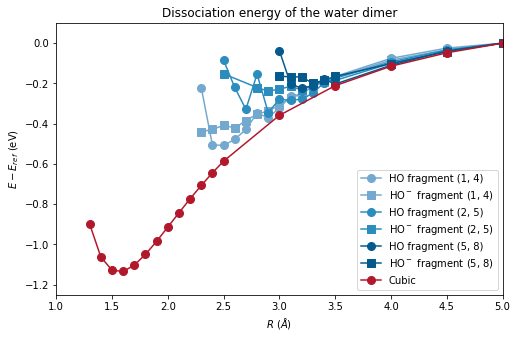

In [16]:
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf']*2 + ['#2b8cbe']*2 + ['#045a8d']*2 + ['#b2182b']
markers = ['o', 's']*3 + ['o']
size = [8]*len(colors)

# Plot with matplotlib
plt.figure(figsize=(8,5))
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i], ms=size[i])
plt.ylim([-1.25, 0.1])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

The problem here is the following: since constraining the extra electron to remain on the HO fragment only, it forbids this extra charge to be localized on the support functions of the water molecule. 
Therefore :

* For large distances, there are no differences, because there is no or little overlap between the support functions of both fragments, the cubic dissociation curve is therefore well-reproduced.

* For short distances, on the other hand, this overlap between the support functions of both fragments becomes important: it gets very difficult to constrain the extra charge on just one fragment. This is the reason why there are so many fluctuations of the energy at short distances: it is not possible to find a minumum of the energy with such a constraint. This explains the difficulties for reaching convergence (the computation time explodes) and why this is even worse for larger nbasis parameters (since the support functions have larger extensions, the overlap is larger for shorter distances).